In [1]:
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
from pathlib import Path
import pprint
import numpy as np
import pandas as pd
import random
import os
from sklearn.decomposition import PCA
from dataset import *
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from train import get_train_test_split, get_batch, trainRNN, trainTransformerClassifier
from models import RNNClassifier, WarmupWithScheduledDropLR, TransformerClassifier, PositionalEncoding
from utils import plot_loss_and_error, set_seed

In [3]:
output_dir = '.'
boc =  BrainObservatoryCache(
manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))
set_seed(50)
cre_lines_to_use = [
    'Cux2-CreERT2',
    'Emx1-IRES-Cre',
    'Fezf2-CreER',
    'Nr5a1-Cre',
    'Ntsr1-Cre_GN220',
    'Rbp4-Cre_KL100',
    'Rorb-IRES2-Cre',
    'Scnn1a-Tg3-Cre',
    'Slc17a7-IRES2-Cre',
    'Tlx3-Cre_PL56',
    ]
exps = get_exps(boc, cre_lines=cre_lines_to_use, targeted_structures=['VISp'], session_types=['three_session_B'])


# torch.save(model.state_dict(), "RNNmodel.pth")
# torch.save(model.state_dict(), "RNNmodel.pt")

In [ ]:
cell_count = []
for exp in exps:
    data_set = boc.get_ophys_experiment_data(exp['id'])
    cids = data_set.get_cell_specimen_ids()
    cell_count.append(len(cids))
plt.hist(cell_count, bins = list(range(0,200,25)))
np.mean(cell_count)

MODEL #1

In [9]:
pre = 15
post = 7
data_type = 'dff'
dataset = prep_dataset(boc, exps[22:23], pre, post, data_type=data_type)
if data_type == 'dff':
    input_dim = dataset['model_input'][0].shape[0] # only for raw dff as input, one exp training at a time
else:
    input_dim = 50
print(f'dataset loaded...')
train_dataset, test_dataset = get_train_test_split(dataset, train_prop = 0.7, split_method = 'trial')
model = RNNClassifier(input_dim=input_dim, hidden_dim=512, embed_dim=512, num_layers=2, num_classes=119, dropout_prob=0.5, nn_type = 'GRU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = WarmupWithScheduledDropLR(optimizer, warmup_epochs=3, initial_lr=0.001, drop_epochs=[30, 70])
epochs = 100
batch_size = 128
clip = 1
model1, train_loss1, train_error1, val_error1, val_loss1 = trainRNN(model, criterion, optimizer, scheduler, epochs, batch_size, clip, train_dataset, test_dataset, dry_run=False)

dataset loaded...
Num parameters:  3257975
training epoch#0


/Users/yuhaoyan/Documents/MCIT/ESE546_Project/.conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuhaoyan/Documents/MCIT/ESE546_Project/.conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


batch#0, running train loss:  nan, running train error:  nan%
batch#0, val loss:  4.77, val error:  100.00%
training epoch#1
batch#0, running train loss:  4.61, running train error:  95.17%
batch#0, val loss:  4.52, val error:  96.09%
training epoch#2
batch#0, running train loss:  4.38, running train error:  93.05%
batch#0, val loss:  4.06, val error:  90.62%
training epoch#3
batch#0, running train loss:  4.21, running train error:  91.18%
batch#0, val loss:  4.03, val error:  89.84%
training epoch#4
batch#0, running train loss:  4.07, running train error:  89.58%
batch#0, val loss:  3.95, val error:  90.62%
training epoch#5
batch#0, running train loss:  3.96, running train error:  88.13%
batch#0, val loss:  3.74, val error:  89.84%
training epoch#6
batch#0, running train loss:  3.86, running train error:  86.95%
batch#0, val loss:  3.54, val error:  82.03%
training epoch#7
batch#0, running train loss:  3.77, running train error:  85.57%
batch#0, val loss:  3.53, val error:  85.94%
tra

MODEL #2

In [4]:
pre = 15
post = 7
data_type = 'pca'
dataset = prep_dataset(boc, exps[19:20], pre, post, data_type=data_type)
if data_type == 'dff':
    input_dim = dataset['model_input'][0].shape[0] # only for raw dff as input, one exp training at a time
else:
    input_dim = 50
print(f'dataset loaded...')
train_dataset, test_dataset = get_train_test_split(dataset, train_prop = 0.7, split_method = 'trial')
model = RNNClassifier(input_dim=input_dim, hidden_dim=512, embed_dim=512, num_layers=2, num_classes=119, dropout_prob=0.5, nn_type = 'GRU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = WarmupWithScheduledDropLR(optimizer, warmup_epochs=3, initial_lr=0.001, drop_epochs=[30, 70])
epochs = 100
batch_size = 128
clip = 1
model2, train_loss2, train_error2, val_error2, val_loss2 = trainRNN(model, criterion, optimizer, scheduler, epochs, batch_size, clip, train_dataset, test_dataset, dry_run=False)

dataset loaded...
Num parameters:  3239031
training epoch#0


/Users/yuhaoyan/Documents/MCIT/ESE546_Project/.conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuhaoyan/Documents/MCIT/ESE546_Project/.conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


batch#0, running train loss:  nan, running train error:  nan%
batch#0, val loss:  4.78, val error:  99.22%
training epoch#1
batch#0, running train loss:  4.68, running train error:  96.36%
batch#0, val loss:  4.57, val error:  91.41%
training epoch#2
batch#0, running train loss:  4.52, running train error:  94.06%
batch#0, val loss:  4.38, val error:  88.28%
training epoch#3
batch#0, running train loss:  4.39, running train error:  92.07%
batch#0, val loss:  4.36, val error:  88.28%
training epoch#4
batch#0, running train loss:  4.28, running train error:  90.63%
batch#0, val loss:  4.08, val error:  86.72%
training epoch#5
batch#0, running train loss:  4.19, running train error:  89.41%
batch#0, val loss:  4.00, val error:  86.72%
training epoch#6
batch#0, running train loss:  4.11, running train error:  88.23%
batch#0, val loss:  4.05, val error:  89.06%
training epoch#7
batch#0, running train loss:  4.05, running train error:  87.31%
batch#0, val loss:  3.97, val error:  85.16%
trai

MODEL#3 TRANSFORMER

In [7]:
set_seed(50)
pre = 15
post = 7
data_type = 'dff'
dataset = prep_dataset(boc, exps[22:23], pre, post, data_type=data_type)
if data_type == 'dff':
    input_dim = dataset['model_input'][0].shape[0] # only for raw dff as input, one exp training at a time
else:
    input_dim = 50
print(f'dataset loaded...')
train_dataset, test_dataset = get_train_test_split(dataset, train_prop = 0.7, split_method = 'trial')
model = TransformerClassifier(input_dim=input_dim, hidden_dim=512, nlayers=1, nhead=8, num_classes=119, dropout=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = WarmupWithScheduledDropLR(optimizer, warmup_epochs=3, initial_lr=0.001, drop_epochs=[30, 70])
epochs = 100
batch_size = 128
model3, train_loss3, train_error3, val_error3, val_loss3 = trainTransformerClassifier(model, criterion, optimizer, scheduler, epochs, batch_size, train_dataset, test_dataset, dry_run=False)

dataset loaded...
training epoch#0


/Users/yuhaoyan/Documents/MCIT/ESE546_Project/.conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuhaoyan/Documents/MCIT/ESE546_Project/.conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


batch#0, running train loss:  nan, running train error:  nan%
batch#0, val loss:  6.00, val error:  100.00%
training epoch#1
batch#0, running train loss:  5.11, running train error:  98.07%
batch#0, val loss:  4.92, val error:  100.00%
training epoch#2
batch#0, running train loss:  4.93, running train error:  97.25%
batch#0, val loss:  4.88, val error:  96.09%
training epoch#3
batch#0, running train loss:  4.80, running train error:  96.22%
batch#0, val loss:  4.57, val error:  94.53%
training epoch#4
batch#0, running train loss:  4.68, running train error:  95.00%
batch#0, val loss:  4.66, val error:  95.31%
training epoch#5
batch#0, running train loss:  4.56, running train error:  93.54%
batch#0, val loss:  4.38, val error:  88.28%
training epoch#6
batch#0, running train loss:  4.44, running train error:  92.24%
batch#0, val loss:  3.98, val error:  85.94%
training epoch#7
batch#0, running train loss:  4.33, running train error:  91.13%
batch#0, val loss:  4.16, val error:  85.94%
tr

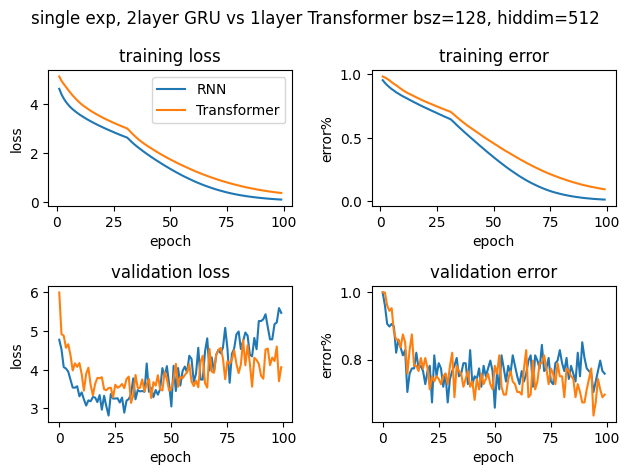

In [10]:
fig, axes = plot_loss_and_error(train_loss1, train_error1, val_loss1, val_error1)
axes[0,0].plot(train_loss3)
axes[0,1].plot(train_error3)
axes[1,0].plot(val_loss3)
axes[1,1].plot(val_error3)
fig.suptitle('single exp, 2layer GRU vs 1layer Transformer bsz=128, hiddim=512')
axes[0,0].legend(['RNN', 'Transformer'])
fig.tight_layout()

In [11]:
fig.savefig('1exp_RNN_vs_transormer.png')